<a href="https://colab.research.google.com/github/dundurlunka/ml-grand-slam/blob/main/ml_grand_slam_more_complex_grid_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read data from github

In [1]:
import pandas as pd
import numpy as np

import sys
import csv

In [ ]:
csv.field_size_limit(sys.maxsize)

points = pd.read_csv('./charting-m-points-from-2017.csv', quoting=csv.QUOTE_NONE, encoding = 'ISO-8859-1')
matches = pd.read_csv('./charting-m-matches.csv', quoting=csv.QUOTE_NONE, encoding = 'ISO-8859-1')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8,9,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Merge the two datasets together by match_id

In [ ]:
joinedData = pd.merge(
    matches,
    points,
    how="inner",
    on='match_id',
)

In [ ]:
df_obj = joinedData.select_dtypes(['object'])
joinedData[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

Select relevant columns from dataframe


In [ ]:
joinedData.columns = joinedData.columns.to_series().apply(lambda x: x.strip())
joinedData = joinedData.loc[:, ['Player 1', 'Player 2', 'Tournament', 'Pl 1 hand', 'Pl 2 hand', 'Surface', 'Set1','Set2', 'Gm1', 'Gm2', 'Pts', 'Serving', '1st', '2nd', 'isAce', 'isUnret']]

In [ ]:
joinedData['isAce'] = joinedData['isAce'] | joinedData['isUnret']
joinedData = joinedData.drop(columns=['isUnret', 'isAce'])

In [ ]:
tennis_players = ['Daniil Medvedev', 'Alexander Zverev', 'Roger Federer', 'Dominic Thiem', 'Nick Kyrgios', 'Novak Djokovic', 'Rafael Nadal', 'Stefanos Tsitsipas', 'Casper Ruud', 'Grigor Dimitrov']
tennis_players_initials = [''.join([x[0].upper() for x in fullname.split(' ')]) for fullname in tennis_players]
joinedData = joinedData.loc[((joinedData['Player 1'].isin(tennis_players)) | (joinedData['Player 2'].isin(tennis_players)))]
joinedData = joinedData.loc[joinedData['Serving'].isin(tennis_players_initials)]

In [ ]:
joinedData[['Pts1', 'Pts2']] = joinedData['Pts'].str.split('-', expand=True)
joinedData = joinedData.drop('Pts', axis='columns')

Separate the columns into new columns that are specific for Server and Returner.

In [ ]:
server_names = []
returner_names = []
pointsServer = []
pointsReturner = []
gamesServer = []
gamesReturner = []
setsServer = []
setsReturner = []
handReturner = []
for index, row in joinedData.iterrows():
    if ''.join([x[0].upper() for x in row['Player 1'].split(' ')]) == row['Serving']:
      server_names.append(row['Player 1'])
      returner_names.append(row['Player 2'])
      pointsServer.append(row['Pts1'])
      pointsReturner.append(row['Pts2'])
      gamesServer.append(row['Gm1'])
      gamesReturner.append(row['Gm2'])
      setsServer.append(row['Set1'])
      setsReturner.append(row['Set2'])
      handReturner.append(row['Pl 2 hand'])
    elif ''.join([x[0].upper() for x in row['Player 2'].split(' ')]) == row['Serving']:
      server_names.append(row['Player 2'])
      returner_names.append(row['Player 1'])
      pointsServer.append(row['Pts2'])
      pointsReturner.append(row['Pts1'])
      gamesServer.append(row['Gm2'])
      gamesReturner.append(row['Gm1'])
      setsServer.append(row['Set2'])
      setsReturner.append(row['Set1'])
      handReturner.append(row['Pl 1 hand'])

joinedData['FullNameServer'] = server_names
joinedData['FullNameReturner'] = returner_names
joinedData['PointsServer'] = pointsServer
joinedData['PointsReturner'] = pointsReturner
joinedData['GamesServer'] = gamesServer
joinedData['GamesReturner'] = gamesReturner
joinedData['SetsServer'] = setsServer
joinedData['SetsReturner'] = setsReturner
joinedData['HandReturner'] = handReturner

joinedData = joinedData.drop(columns=['Player 1', 'Player 2', 'Pts1', 'Pts2', 'Gm1', 'Gm2', 'Set1', 'Set2', 'Pl 1 hand', 'Pl 2 hand', 'Serving'])

Combine the serves into one column with a list of 1 or 2 serves so that it can be exploded into several rows later

In [ ]:
joinedData['Serves'] = joinedData.apply(lambda x: list(['f' + str(x['1st']),
                                                        's' + str(x['2nd'])]), axis=1)   

Explode list of first and second serve into separate rows

In [ ]:
joinedData = joinedData.explode('Serves')

Add new column indicating whether the serve was first or second

In [ ]:
joinedData['IsFirstServe'] = joinedData['Serves'].str[0] == 'f'

Remove 'f' and 's' (first and second serve) that were indicators before the explosion

In [ ]:
joinedData['Serves'] = joinedData['Serves'].str[1:]
joinedData = joinedData[(joinedData['Serves'] != 'nan') & (joinedData['Serves'] != '')]
joinedData = joinedData.drop(columns=['1st', '2nd'])

Remove lets

In [ ]:
joinedData['Serves'] = joinedData['Serves'].map(lambda x: x.lstrip('c'))

In [ ]:
joinedData['FullNameServer'].value_counts()
joinedData['FullNameReturner'].value_counts()

Novak Djokovic        5698
Rafael Nadal          4634
Stefanos Tsitsipas    4454
Daniil Medvedev       4011
Alexander Zverev      3736
                      ... 
Ryan Harrison           72
Daniel Elahi Galan      71
Ugo Humbert             66
Peter Gojowczyk         59
Michael Geerts          49
Name: FullNameReturner, Length: 143, dtype: int64

Extract direction of serve

In [ ]:
def extract_serve_direction(row):
  serves_directions_dict = {
      '4': 'Out wide',
      '5': 'Body',
      '6': 'Down the T'
  }

  if len(row['Serves']) > 1 and row['Serves'][1] in ['x', 'd', 'w', 'n', 'g', '!', 'e']:
      return "Fault"
  else:
      return serves_directions_dict.get(row['Serves'][0], 'Body')

joinedData['Direction'] = joinedData.apply(extract_serve_direction, axis=1)
joinedData = joinedData.drop(columns='Serves')

In [ ]:
joinedData.to_csv('wrangled-data.csv')

# Start of machine learning

### Data exploration

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [3]:
joinedData = pd.read_csv('./wrangled-data.csv')
joinedData = joinedData.drop(columns=['Unnamed: 0'])

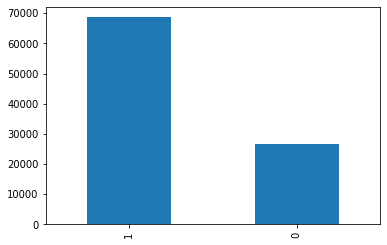

In [6]:
joinedData['Direction'].value_counts().plot(kind='bar')

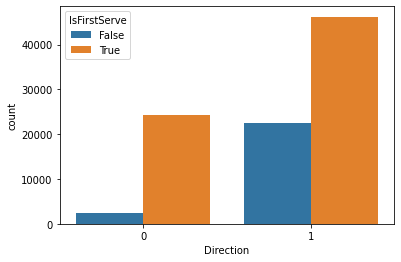

In [8]:
sns.countplot(
    x = 'Direction',
    hue = 'IsFirstServe',
    data = joinedData,
)

## Pre-processing

In [4]:
X = joinedData.drop(columns=['Direction'])
y = joinedData['Direction']

### One hot encoding attributes

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

categorical_columns = ['Surface', 'FullNameServer', 'FullNameReturner', 'PointsServer', 'PointsReturner', 'HandReturner', 'Tournament']

encoded_X = pd.get_dummies(X, columns=categorical_columns)

In [ ]:
encoded_X.to_csv('encoded_attributes.csv')

### Label encoding the label

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_y = le.fit_transform(y)

### Splitting into train test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(encoded_X, encoded_y)

## KNN

In [16]:
def plot_knn_scores(ks):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = KNeighborsClassifier(n_neighbors=k, scoring=).fit(X_train, y_train)

        print('finding scores for ' + str(k) + ' k neares neighbours')

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)              

        print('found scores for ' + str(k) + ' k neares neighbours\n' + f'train_score: {train_score}\n' + f'test_score: {test_score}')

        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(ks, train_scores, color='blue', label='train score')
    plt.plot(ks, test_scores, color='green', label='test score')
    plt.legend()

In [17]:
plot_knn_scores(range(1, 15, 2))

finding scores for 1 k neares neighbours


KeyboardInterrupt: ignored

## Logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression

def plot_logistic_regression_scores(cs):
    train_scores = []
    test_scores = []
    
    for c in cs:
        regression = LogisticRegression(C=c).fit(X_train, y_train)

        print(f'finding scores for c={c}')

        train_score = regression.score(X_train, y_train)
        test_score = regression.score(X_test, y_test)              

        print(f'found train score for c={c}: {train_score}')

        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(cs, train_scores, color='blue', label='train score')
    plt.plot(cs, test_scores, color='green', label='test score')
    plt.legend()

finding scores for c=0.001
found train score for c=0.001: 0.7208391060357977


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


finding scores for c=0.01
found train score for c=0.01: 0.7208391060357977


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


finding scores for c=0.1
found train score for c=0.1: 0.7208391060357977


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


finding scores for c=1
found train score for c=1: 0.7209230726170984


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


finding scores for c=10
found train score for c=10: 0.7209090781868817


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


finding scores for c=1000
found train score for c=1000: 0.7208810893264481


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


finding scores for c=10000
found train score for c=10000: 0.7208950837566649


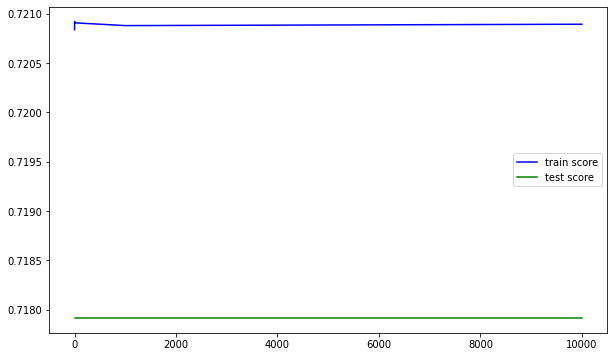

In [11]:
plot_logistic_regression_scores([0.001, 0.01, 0.1, 1, 10, 1000, 10000])

In [9]:
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define model
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
weights = np.linspace(0.0, 0.99, 100)

# define search space
space = dict()
# space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
# space['class_weight'] = [{0:x, 1:1.0-x} for x in weights]

# define search
search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solve

Best Score: 0.8369060980231565
Best Hyperparameters: {'C': 1e-05, 'penalty': 'l2'}


In [11]:
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define model
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
weights = np.linspace(0.0, 0.99, 20)

# define search space
space = dict()
# space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
space['class_weight'] = [{0:x, 1:1.0-x} for x in weights]

# define search
search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3000 fits failed out of a total of 6000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3000 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: So

Best Score: 0.8369060980231565
Best Hyperparameters: {'C': 1e-07, 'class_weight': {0: 0.0, 1: 1.0}, 'penalty': 'l2'}


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [18]:
pd.set_option('display.max_rows', 500)
joinedData.head(500)

,Tournament,Surface,FullNameServer,FullNameReturner,PointsServer,PointsReturner,GamesServer,GamesReturner,SetsServer,SetsReturner,HandReturner,IsFirstServe,Direction
0,Tour Finals,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,0,0,R,True,0
1,Tour Finals,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,0,0,R,False,1
2,Tour Finals,Hard,Novak Djokovic,Casper Ruud,0,15,0,0,0,0,R,True,0
3,Tour Finals,Hard,Novak Djokovic,Casper Ruud,0,15,0,0,0,0,R,False,1
4,Tour Finals,Hard,Novak Djokovic,Casper Ruud,15,15,0,0,0,0,R,True,1
5,Tour Finals,Hard,Novak Djokovic,Casper Ruud,30,15,0,0,0,0,R,True,0
6,Tour Finals,Hard,Novak Djokovic,Casper Ruud,30,15,0,0,0,0,R,False,1
7,Tour Finals,Hard,Novak Djokovic,Casper Ruud,40,15,0,0,0,0,R,True,1
8,Tour Finals,Hard,Casper Ruud,Novak Djokovic,0,0,0,1,0,0,R,True,0
9,Tour Finals,Hard,Casper Ruud,Novak Djokovic,0,0,0,1,0,0,R,False,1
